- Visualize the time series data
- Make the time series stationary
- Plot correlation and autocorrelation charts
- Constuct the ARIMA model or Seasonal ARIMA model based on the data
- Use the model to make the prediction

In [48]:
import pandas as pd

In [49]:
data = pd.read_csv('C:/TimeSeriesProject/time_series.csv')
data.head()

,Month,sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [50]:
data.isna().sum()

Month    1
sales    2
dtype: int64

In [51]:
data = data.dropna()

In [52]:
data['Month'] = pd.to_datetime(data['Month'])

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   105 non-null    datetime64[ns]
 1   sales   105 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.5 KB


In [54]:
data.head()

,Month,sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [55]:
data.describe()

,sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


In [56]:
data = data.set_index('Month')

<AxesSubplot:xlabel='Month'>

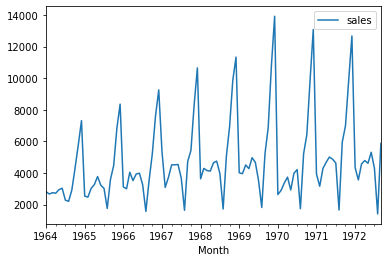

In [57]:
data.plot()

The data here is seasonal 

In [58]:
# To check if the data is stationary we use Dickey–Fuller test

In [59]:
from statsmodels.tsa.stattools import adfuller

In [60]:
# H0 : It is non stationary
# H1 : It is stationary

def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF test statistics','P val','Lags Used','No. of obs used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print('Reject the null hypothesis')
    else:
        print('Accept the null hypothesis')

In [61]:
adfuller_test(data)

ADF test statistics : -1.8335930563276195
P val : 0.3639157716602467
Lags Used : 11
No. of obs used : 93
Accept the null hypothesis


Here the pval is less than 0.05 hence we accept the null hypothesis ie. data is non stationary.

To fix the non stationary data we can use differencing method

Here since the data is seasonal we will do seasonal difference

In [62]:
data['seasonal_diff'] = data['sales'] - data['sales'].shift(12)

In [63]:
# Now testing if this seasonal diff. is stationary
adfuller_test(data['seasonal_diff'].dropna())

ADF test statistics : -7.626619157213166
P val : 2.0605796968136632e-11
Lags Used : 0
No. of obs used : 92
Reject the null hypothesis


We reject the H0 hence H1 is true ie. we can say the seasonal diff is stationary

<AxesSubplot:xlabel='Month'>

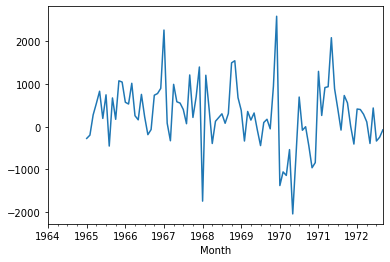

In [17]:
data['seasonal_diff'].plot()

Autocorrelation and Partial Autocorrelation
- Identification of an AR model is often best done with the PACF.
- Identification of an MA model is often best done with the ACF.

p,d,q -> p - AR model lags (PACF),  d - differencing, q - MA lags (ACF)

In [18]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import matplotlib.pyplot as plt

C:\Users\Aditya\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


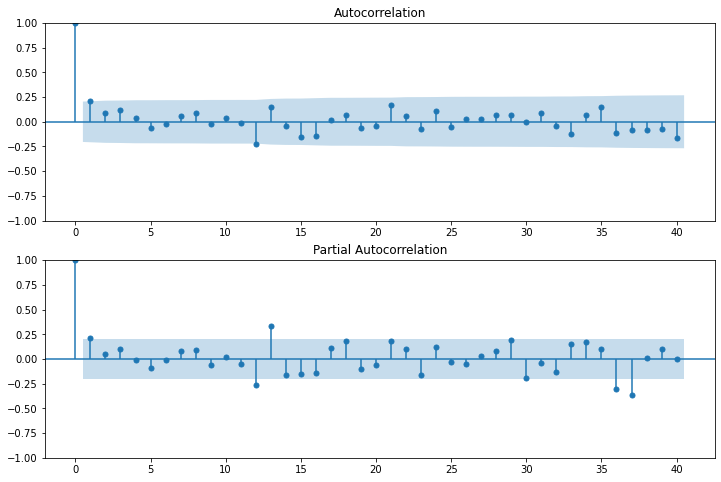

In [19]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['seasonal_diff'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['seasonal_diff'].iloc[13:],lags=40,ax=ax2)

Here p = 1 , d = 1 , q = 0 or 1

In [20]:
data.shape

(105, 2)

In [64]:
model=sm.tsa.statespace.SARIMAX(data['sales'],order=(1,1,1),seasonal_order=(1,1,1,12))
results=model.fit()

C:\Users\Aditya\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Aditya\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='Month'>

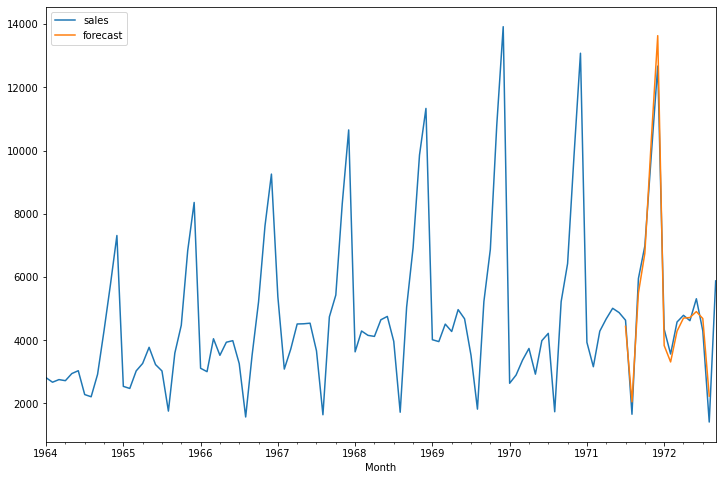

In [22]:
data['forecast']=results.predict(start=90,end=103,dynamic=True)
data[['sales','forecast']].plot(figsize=(12,8))

In [23]:
from pandas.tseries.offsets import DateOffset
future_dates=[data.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [24]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=data.columns)

<AxesSubplot:>

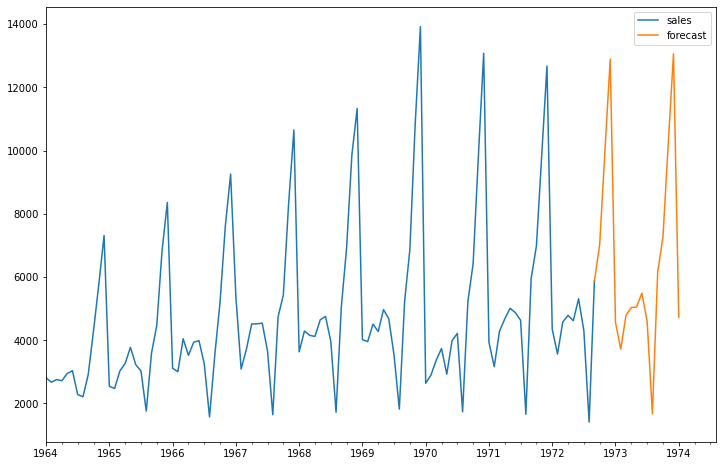

In [25]:
future_df=pd.concat([data,future_datest_df])
future_df['forecast'] = results.predict(start = 104, end = 120, dynamic= True)  
future_df[['sales', 'forecast']].plot(figsize=(12, 8)) 